<small><img src=https://raw.githubusercontent.com/ia4legos/MachineLearning/main/images/IASAC-UMH.png width="450" height="200"></small>


# <font color="steelblue">Clasificador Naïve Bayes: Introducción y algoritmo para dos grupos</font>

**Autoría**: 

*   Fernando Borrás (f.borras@umh.es)
*   Federico Botella (federico@umh.es)
*   Inés Hernández (ines.hernandezp@umh.es)
*   Mª Asunción Martínez Mayoral (asun.mayoral@umh.es)
*   Josep Moltó (j.molto@umh.es)
*   Javier Morales (j.morales@umh.es) 

Departamento de Estadística, Matemáticas e Informática. 

Universidad Miguel Hernández de Elche. 


**Financiación**: El material que aparece a continuación se ha desarrollado dentro del marco del proyecto UNIDIGITAL- IASAC.

**Fecha última edición**: 05/03/2023

**Licencia**: <small><a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /></small>

No olvides hacer una copia si deseas utilizarlo. Al usar estos contenidos, acepta nuestros términos de uso y nuestra política de privacidad. 


## <font color="steelblue">Configuración del cuaderno</font>

Para garantizar la funcionalidad completa de este cuaderno, es preciso ejecutar la celda de código a continuación.

In [ ]:
#@title <b><font color="steelblue" size="+1"> Configuración de cuaderno

# Cargamos módulos
from io import StringIO 
import sys
import numpy as np      # importamos numpy como np
import pandas as pd     # importamos pandas como pd
import math             # importamos módulo para cáculos matemáticos

# Esta línea configura matplotlib para mostrar las figuras incrustadas en el jupyter notebook
# Configuraciónde entorno gráfico
%matplotlib inline
import matplotlib.pyplot as plt # importamos matplotlib como plt
import seaborn as sns # importamos seaborn como sns
sns.set_style("ticks")
%config InlineBackend.figure_format = 'retina'

class Capturing(list):
    def __enter__(self):
        self._stdout = sys.stdout
        sys.stdout = self._stringio = StringIO()
        return self
    def __exit__(self, *args):
        self.extend(self._stringio.getvalue().splitlines())
        del self._stringio    # free up some memory
        sys.stdout = self._stdout

with Capturing() as output:
    print('Comenzamos....')

with Capturing(output) as output:
    # Librerías
    import os
    !pip install jupyterquiz
    from jupyterquiz import display_quiz
    import json
    import base64
    # Lectura ficheros json
    # A configurar pra cada cuaderno en función de las preguntas de autoevalaución
    for i in range(1,7):
      !wget {f"https://raw.githubusercontent.com/ia4legos/MachineLearning/main/autoeval/auto_50_{i}.json"}
    print("Cuaderno configurado")

if output[-1]=='Cuaderno configurado':
    print(output[-1])
else: 
    print(output[:-2])

Cuaderno configurado


# <font color="steelblue">Introducción</font>

**Descripción:** En este cuaderno se realiza una aproximación a los modelos de clasificación Naïve Bayes y se estudian extensamente los utilizados para la clasificación con dos grupos. Se presenta cómo obtenerlos utilizando la librería Scikit-Learn. Se introducen también los modelos para múltiples grupos. Se ejemplifica el uso de los Naïve Bayes para dos grupos sobre diferentes ejemplos reales.

**Nivel de Formación:** B

**Recomendaciones antes de usarlo:** Resulta de utilidad conocimientos básicos de probabilidad y más especifícamente del teorema de Bayes.



## <font color="steelblue">Objetivos de aprendizaje</font>

* Conocer las diferentes versiones de los algoritmos Naïve Bayes para tareas de clasificación en la implantación de un proceso de aprendizaje automático. 
* Implementar los algoritmos Naïve Bayes para tareas de clasificación en dos grupos.
* Realizar el análisis de validación del proceso de clasificación resultante de un algoritmo Naïve Bayes para dos grupos.
* Llevar a cabo el proceso de calibración para estimar de forma efectiva las probabilidades de clasificación de cada grupo. 
* Aplicar los algoritmos Naïve Bayes para la tarea de clasificación de dos grupos en situaciones reales. 




## <font color="steelblue">Contenidos</font>

1. ¿Qué son los clasificadores Naïve Bayes?
2. Tipos de clasificadores Naïve Bayes
  * Naïve Bayes Bernouilli
  * Naïve Bayes Multinomial
  * Naïve Bayes Gaussiano
3. Calibración de probabilidades
4. Ventajas e inconvenientes de los clasificadores Naïve Bayes
5. Aplicaciones reales de los clasificadores Naïve Bayes
6. Solución matemática de los clasificadores Naïve Bayes para dos grupos
7. Clasificadores Naïve Bayes para dos grupos en Scikit-Learn
  * Clasificación y estimación de probabilidades
  * Calibración de probabilidades
  * Métricas y validación de la clasificación
8. Aplicaciones
9. Referencias y enlaces de interés

# <font color="steelblue">¿Qué son los clasificadores Naïve Bayes?</font>

Con este cuaderno estrenamos el bloque específico de algortimos de aprendizaje automático centrados en los problemas de clasificación. En un problema de clasificación tenemos disponible la información de $n$ muestras mediante:

* Una variable respuesta $y$ de tipo categórico con $k$ categorías o etiquetas (que es el nombre que reciben habitualmente dentro del aprendizaje automático) $y_1,...,y_k$,

* Un conjunto de variables predictoras $X=(X_1,...,X_p)$ que pueden influir de forma distinta en cada una de las etiquetas de la respuesta.

La estructura es muy similar a la de los problemas de regresión logística pero en este caso no disponemos de un modelo sino que tratamos de predecir directamente la probabilidad  de cada etiqueta de la respuesta para una nueva muestra dada en función de las variables predictoras registradas.

Los clasificadores Naïve Bayes son los primeros algoritmos de clasificación que vamos a estudiar, dado que se utilizan en muchas ocasiones como modelo de base o partida en los problemas de clasificación, ya que son extremadamente rápidos y sencillos y suelen ser adecuados para conjuntos de datos de muy alta dimensión.

Los clasificadores Bayes se basan en el teorema de Bayes, que es una ecuación que describe la relación de las probabilidades condicionales entre dos conjuntos de sucesos. En nuestro caso estamos interesados en determinar la probabildiad de una clase, del conjunto posible, en función del conjunto de predictoras observadas $$P(y_l|x_1,...,x_p)$$ para $l=1,...,k$, donde $x_1,...,x_p$ son los valores observados de las predictoras para una muestra dada. Dicha probabilidad se puede escribir utilizando dicho teorema como:

$$P(y_l|x_1,...,x_p) = \frac{P(x_1,...,x_p|y_l)P(y_l)}{P(x_1,...,x_p)}$$

donde $P(x_1,...,x_p|y_l)$ es la verosimilitud para una etiqueta dada, $P(y_l)$ es la probabilidad previa de cada clase antes de la toma de datos, $P(x_1,...,x_p)$ es la información marginal aportada por los datos, y $P(y_l|x_1,...,x_p)$ es la distribución posterior de la clase $l$ dada la información recogida. La distribución posterior cuantifica la probabilidad de cada clase dado el conjunto de datos observado. Para evaluar dicho cociente los algortimos Naïve Bayes asumen independencia entre las observaciones de forma que:

$$P(x_1,x_2,...,x_p| y) = P(x_1|y)P(x_2|y)...P(x_p|y)=\prod_{i=1}^p P(x_i|y)$$

Para la estimación de $P(y)$ utilizamos la proporción de cada clase en la muestra de entrenamiento.

De esta forma, la regla de clasificación para determinar la clase $l$ a la que debemos asignar una muestra se obtiene evaluando las expresiones: 

$$\underset{l}{max}\left[ P(y_l)\prod_{i=1}^p P(x_i|y_l)\right], \quad l=1,...,k$$



# <font color="steelblue">Tipos de clasificadores Naïve Bayes</font>





Dentro de los clasificadores Naïve Bayes encontramos tres tipos principales en función de las características de la variable respuesta y las predictoras. Dichos tipos son: **Naïve Bayes Bernouilli**, **Naïve Bayes Multinomial**, y **Naïve Bayes Gaussiano**.


## <font color="steelblue">Naïve Bayes Bernouilli</font>


El algoritmo **Naïve Bayes Bernouilli** se utiliza cuando tanto la respuesta como las predictoras tienen únicamente dos etiquetas o categorías, es decir, son variables de tipo binario. En esta situación si la variable $y$ solo puede tomar los valores $\{0,1\}$, la verosimilitud individual de cada predictora se expresa como:

$$P(x_i|y) = P(y=1)x_i+(1-P(y=1))(1-x_i)$$

con la que podemos obetener de forma muy rápida la regla de clasificación para este algoritmo ya que esta viene dada por elegir a clase 1 si:

$$[P(y=1)^{q+1}] > [P(y=0)^{p-q+1}]$$

donde $p$ es el número de predictoras disponibles, $q$ el número de predictoras que toman el valor 1 para la muestra que tratamos de clasificar, y $P(y=1)$, $P(y=0)$ se estiman a partir de los valores de la muestra de entrenamiento. 

Por lo tanto, este tipo de clasificador requiere que las muestras se representen como vectores de características de tipo binario. Es el algoritmo menos utilizado de los tres debido a sus restricciones de aplicación pero es el que proporciona una solución más rápida en este tipo de situaciones.

## <font color="steelblue">Naïve Bayes Multinomial</font>

Se utiliza cuando la variable respuesta tiene dos o más etiquetas posibles, y las variables predictoras son de tipo categórico multinomial, es decir, con múltiples etiquetas en cada una de ellas. Es un algoritmo muy extendido que se ha utilizado en la clasificación de textos como por ejemplo la identificación de correo en Spam versus No Spam. Este algoritmo evalúa la probabilidad de cada etiqueta para una muestra determinada y devuelve la etiqueta con la mayor posibilidad. 

En este caso si $\theta_{y_l}=(\theta_{y_l;1},...,\theta_{y_l;p})$ representa el vector de probabilidades para la clase $l$ asociada con el conjunto de predictoras, podemos estimar dichos parámetros mediante la expresión:

$$\hat{\theta}_{y_l;j} = \frac{N_{y_l;j} + \alpha}{N_{y_l} + \alpha n},$$

donde $N_{y_l;j}$ es el número de predictoras de la muestra con valor 1 para la clase l, $N_{y_l} = \sum_{j=1}^n N_{y_l;j}$, y $\alpha$ es el parámetro de suavizado que tiene en cuenta las clases que no están presentes en las muestras de aprendizaje y evitan las probabilidades nulas en los cálculos posteriores. El ajuste se denomina suavizado de Laplace cuando $\alpha=1$, mientras que se denomina suavizado de Lidstone cuando $\alpha < 1$.



## <font color="steelblue">Naïve Bayes Gaussiano</font>

Es una variante del Naive Bayes Multinomial donde las variables predictoras son todas de tipo numérico. Todas ellas se distribuyen mediante una distribución Normal Multivariante. Este algoritmo hace uso de las medias y desviaciones estándar de las predictoras para obtener la probabilidad de clasificación de cada etiqueta de la respuesta. En este caso las verosimilitudes necesarias para la regla de clasificación se obtienen a partir de la función de densidad de la distribución normal como:

$$P(x_i|y) = \frac{1}{\sqrt{2\pi\sigma_y^2}}exp\left(-\frac{(x_i-\mu_y)^2}{2\sigma_y^2}\right),$$

donde los parámetros $\mu_y$ y $\sigma_y^2$ se estiman por máxima verosimilitud a partir de la información contenida en la muestra de entrenamiento, es decir, las medias y varianzas muestrales de cada predictora cuando estamos en la clase $l$.

# <font color="steelblue">Calibración de probabilidades</font>

Muchos de los modelos de machine learning empleados en problemas de clasificación son capaces de estimar un valor de probabilidad asociado a cada predicción, es decir, la probabilidad de ocurrencia de cada una de las clases de la variable respuesta. Sin embargo, ¿hasta qué punto las probabilidades obtenidas pueden interpretarse directamente como un nivel de confianza para la clasificación? Aquí es donde entra en juego el concepto de calibración.

Los clasificadores bien calibrados son aquellos que se basan en el cálculo de probabilidades que se pueden interpretar directamente como un nivel de confianza. Por ejemplo, un clasificador (binario) bien calibrado debería clasificar las muestras de tal manera que entre las muestras a las que dio un valor de probabilidad de clasificación para una clase cercano a 0.8, aproximadamente el 80% de las muestras deben pertenecer a dicha clase.

La calibración de un modelo de clasificación consiste en reajustar las probabilidades predichas para que correspondan con la proporción de casos reales observados. En otras palabras, corregir las probabilidades predichas por un modelo cuando este las subestima o sobrestima.

Un modelo está perfectamente calibrado cuando, para cualquier valor  $𝑝$ , la clasificación predicha con una confianza (probabilidad) de  $𝑝$  es correcta el  $100∗𝑝$  por ciento de las veces. Por ejemplo, si se seleccionan las observaciones cuya probabilidad predicha es  $\hat{p} = 0.8$, es de esperar que el porcentaje de esas observaciones bien clasificadas sea del 80%.

El proceso más empleado para saber si un modelo está bien calibrado es generar la curva de calibrado o *reliability plots*. La forma de calcularla es:

* Se ordenan todas las predicciones del modelo de menor a mayor probabilidad y se agrupan en intervalos (bins).
* Se calcula la proporción de clasificaciones correctas en cada bin (proporción empírica).
* Se calcula la confianza del bin como el valor promedio de las probabilidades estimadas por el modelo para todas las observaciones que forman parte del bin (confianza del modelo).

Cuanto mejor calibrado esté el modelo, más próximos serán los valores de proporción empírica y de confianza, es decir, más se aproxima la curva obtenida a la diagonal. La curva de calibrado queda por encima de la diagonal si el modelo tiende a infravalorar las probabilidades y por debajo si las sobrevalora.

Aunque las curvas de calibración aportan información detallada, es interesante disponer de una métrica que permita cuantificar con un único valor la calidad de calibración del modelo. El coeficiente de Brier es la diferencia cuadrática media (mean squared difference) entre la probabilidad estimada por el modelo y la probabilidad real (1 para la clase positiva y 0 para la negativa). Cuanto menor es su valor, mejor calibrado está el modelo. Esta métrica es adecuada solo para clasificaciones binarias.

Calibrar un clasificador consiste en ajustar un regresor que asigna la salida del clasificador a una probabilidad calibrada en $[0, 1]$. Si denotamos la salida del clasificador para una muestra dada por $f_i$, el calibrador intenta predecir $p(y_i=1|f_i)$.

Las muestras que se utilizan para ajustar el calibrador no deben ser las mismas que se utilizan para ajustar el clasificador, ya que esto introduciría un sesgo. Esto se debe a que el rendimiento del clasificador en sus datos de entrenamiento sería mejor que para los datos nuevos. Utilizar la salida del clasificador de los datos de entrenamiento para ajustar el calibrador daría como resultado un calibrador sesgado que asigna probabilidades más cercanas a 0 y 1 de lo que debería. Para evitar estos problemas se suelen utilizar procedimientos de validación cruzada para calibrar el modelo.

Los calibradores habituales utilizados son:

**Calibrador sigmoide** basado en el modelo de regresión de Platt dado por la ecuación:

$$P(y_i=1|f_i)=\frac{1}{1+exp(Af_i+B)},$$

donde $y_i$ es el verdadero valor para la muestra $i$, $f_i$ es el valor obtenido por el calibrador, y $A$ y $B$ son valores que se obtienen cuando ajustamos el regresor por máxima verosimilitud.

En general, este método es más eficaz cuando el modelo no calibrado está infravalorado y tiene errores de calibración similares para las salidas altas y bajas.

**Calibrador isotónico** que ajusta un regresor no paramétrico, que produce una función escalonada no decreciente minimizando:

$$\sum_{i=1}^n (y_i - \hat{f}_i)^2,$$

con la restricción de que $\hat{f_i} \geq \hat{f_j}$ siempre que $f_i \geq f_j.$ 

Este método es más general en comparación con el "sigmoide", ya que la única restricción es que la función de calibración sea monotónicamente creciente. Por tanto, es más potente, ya que puede corregir cualquier distorsión monótona del modelo no calibrado. Sin embargo, es más propenso a sobreajustarse, especialmente en conjuntos de datos pequeños. En general, esta calibración funcionará tan bien o mejor que "sigmoide" cuando haya suficientes datos (más de ~ 1000 muestras) para evitar el sobreajuste.

Tanto los regresores isotónicos como los sigmoides sólo admiten datos unidimensionales (por ejemplo, salida de clasificación binaria), pero se amplían para la clasificación multiclase si el algoritmo utilizado admite predicciones multiclase. En este caso, al predecir las probabilidades, estas son calibradas para cada clase por separado. Como esas probabilidades no suman necesariamente uno, se realiza un posprocesamiento para normalizarlas.



# <font color="steelblue">Ventajas e incovenientes de los clasificadores Naïve Bayes</font>

Los clasificadores Naïve Bayes tienden a funcionar especialmente bien en cualquiera de las siguientes situaciones:

* Cuando las clases de la respuesta están bien separadas, es decir, la distribución de probabilidad posterior de las clases en función de las predictoras son diferentes.
* Cuando disponemos de una gran cantidad de predictoras y la complejidad del modelo no es relevante.

Estos dos puntos están relacionados ya que a medida que aumenta la dimensión de un conjunto de datos, es mucho menos probable que se descubran dos puntos cercanos entre sí. Esto significa que las agrupaciones en dimensiones altas tienden a estar más separadas que las agrupaciones en dimensiones bajas.

El clasificador Naïve Bayes tiene además las siguientes ventajas computacionales:

* Es extremadamente rápido tanto para el entrenamiento como para la predicción, y por tanto tiene un coste de cálculo muy bajo.
* Proporciona una predicción probabilística directa.
* Puede trabajar eficazmente en un gran conjunto de datos.
* Cuando se cumple el supuesto de independencia (algo que en la práctica es bastante díficil), un clasificador Naïve Bayes funciona mejor en comparación con otros modelos como la regresión logística.

Entre las deventajas de este algoritmo podemos mencionar:

* La hipótesis de la independencia condicional no siempre se cumple. En la mayoría de las situaciones, las variables predictoras muestran alguna forma de dependencia.

* El problema de la probabilidad cero hace referencia a las situaciones en las que en la muestra de test tenemos valores de la respuesta que no estaban en la muestra de entrenamiento. Esto provoca automáticamente que la probabilidad de esa clase sea siempre cero. Por ese motivo hay que tener cuidado y analizar con detalle la muestra de entrenamiento para asegurar de que se dispone de valores de  todas las clases de la respuesta.



# <font color="steelblue">Aplicaciones reales de los clasificadores Naïve Bayes</font>

Por su sencillez, el algoritmo Naïve Bayes tiene muchas aplicaciones en diversos sectores, como la salud, la tecnología, el medio ambiente, etc. Estas son algunas de las más habituales:

* La aplicación más habitual es en la clasificación de textos. Por ejemplo, las noticias en la web están creciendo rápidamente y cada sitio de noticias tiene su propia disposición y categorización para agruparlas. Para conseguir mejores resultados de clasificación, aplicamos el clasificador Naïve Bayes para determinar  el tipo de noticia basándonos en el contenido de las mismas, a partir de la extracción de palabras clave.

* Quizás la aplicación más antigua y que tiene que ver con el análisis de textos del punto anterior es el filtrado de spam en el correo electrónico. Los clasificadores de Naïve Bayes funcionan correlacionando el uso de "tokens" (normalmente palabras, o a veces otras cosas) que pueden ir asociados con correos que pueden ser clasificados como spam y los que no son, y luego utilizan el teorema de Bayes para calcular la probabilidad de que un correo electrónico sea o no spam.

* Es un algoritmo habitual dentro del ámbito de la salud donde para cada sujeto hay mucha información disponible, ya que el clasificador Naïve Bayes tiene en cuenta la evidencia de todos los atributos considerados para determinar la probabildiad de que el sujeto padezca o no cierta enfermedad, proporcionando una herramienta muy sencilla para la toma de decisiones. 

* Otro ámbito de aplicación de estos algoritmos es en la predicción del tiempo en situaciones simples. Los algorirmos Naïve Bayes aprovechan la información pasada para predecir la situación climática (soleado, nuboso, lluvioso) en base a la probabilidad posterior de cada una de las situaciones posibles.

* Dos aplicaciones más modernas y de gran utilización en el ámbito del aprendizaje automático son el análisis de sentimientos y la construcción de sistemas de recomendación. El Análisis de Sentimientos se refiere a la identificación de los sentimientos positivos o negativos de un grupo objetivo a partir de la información recogida sobre ellos (opiniones respecto de un tema en particular). En este caso el análisis de reputación de las personas u organismos es un campo de aplicación habitual del análisis de sentimientos. Por otro lado, el denominado Filtrado Colaborativo y el algoritmo Naïve Bayes se complementan para los sistemas de recomendación que tratan de ofrecer al usuario de portales de internet una colección de productos o servicios en los que el usuario podría estar interesado. Estos algoritmos se usan por ejemplo en plataformas como Amazon o Netflix. 

# <font color="steelblue">Solución matemática de los clasificadores Naïve Bayes para dos grupos</font>

Para mostrar el uso de los algoritmos Naïve Bayes planteamos un ejemplo muy sencillo donde resolveremos el problema de clasificación manualmente. 

Tenemos un conjunto de datos compuesto por 14 muestras donde se ha recogido información sobre la realización de una actividad deportiva después de comer en función del clima de ese día al amanecer. Se establecen tres situaciones climáticas para cada día (Soleado, Nublado y Lluvioso) y si se realizó la actividad deportiva o no. Estamos interesados en saber si se celebrará o no la actividad deportiva la próxima semana en función del clima de ese día al amanecer. A continuación se presentan los datos recogidos:

In [ ]:
# Datos de prueba
datos = {'Tiempo': ['Soleado', 'Soleado', 'Nublado','Lluvioso','Lluvioso','Lluvioso', 'Nublado', 'Soleado', 
                    'Soleado', 'Lluvioso', 'Soleado','Nublado','Nublado','Lluvioso'], 
         'Jugar': ['Si','Si','No','No','Si','No','Si','No','Si','Si','Si','Si','No','No'],
         'Dia': [1,2,3,4,5,6,7,8,9,10,11,12,13,14]}
df = pd.DataFrame.from_dict(datos)
df.set_index('Dia')
# tabla de resultados pasados
tb = pd.pivot_table(df, values = 'Dia',         
                       index = 'Tiempo',           
                       columns = 'Jugar',          
                       aggfunc = {'Dia': 'count'},               
                       fill_value = 0)         
tb

Jugar,No,Si
Tiempo,,
Lluvioso,3,2
Nublado,2,2
Soleado,1,4


En primer lugar obtenemos las probabilidades marginales de ambos tipos de sucesos como las marginales por filas o columnas de la tabla anterior, de forma que:

$$P(Lluvioso) = 5/14; P(Nublado) = 4/14; P(Soleado)=5/14$$

$$P(Si)=8/14; P(No)=6/14$$

Debemos obtener ahora las verosmilitudes dadas por las probabildiades condicionadas:

$$P(clima|actividad)$$

que en este caso son:

$$P(Lluvioso|Si) = 2/8; P(Lluvioso|No) = 3/6$$
$$P(Nublado|Si) = 2/8; P(Nublado|No) = 2/6$$
$$P(Soleado|Si) = 4/8; P(Soleado|No) = 1/6$$

Podemos obtener las distribuciones posteriores necesarias para la clasificación utilizando el teorema de Bayes, de forma que:

$$P(Si|Lluvioso) = \frac{P(Lluvioso|Si)P(Si)}{P(Lluvioso)}=\frac{2/8*8/14}{5/14}=2/5 = 0.20$$

$$P(Si|Nublado) = \frac{P(Nublado|Si)P(Si)}{P(Nublado)}=\frac{2/8*4/14}{4/14}=1/4 = 0.25$$

$$P(Si|Soleado) = \frac{P(Soleado|Si)P(Si)}{P(Soleado)}=\frac{4/8*9/14}{5/14}=9/10 = 0.90$$

Podemos obtener las probabilidades complementarias $P(No|Clima)$ como $1-P(Si|Clima)$, de forma que si el día es Soleado la ratio de clasificación entre realizar y no realizar la actividad es $0.9/0.1 = 9$, luego clasificamos como que realizaremos la actividad si el día es soleado, ya que es 9 veces más probable. Podemos utilizar un razonamiento similar en las otras dos situaciones concluyendo que si el día es Lluvioso lo más probable es que no se haga la actividad (ratio igual a 0.2/0.8=0.25), mientras que si el día es nublado tenemos una posibilidad sobre tres de que si se haga la actividad deportiva.


Una vez visto este ejemplo tan trivial pasamos a presentar las herramientas que proporciona Scikit-Learn para utilizar los algortimos Naïve Bayes, comenzando por la situación más sencilla donde la variable respuesta sólo tiene dos etiquetas posibles.

# <font color="steelblue">Clasificadores Naïve Bayes para dos grupos en Scikit-Learn</font>

En la clase `naive_bayes` de Scikit-Learn se encuentran disponibles las funciones:

* `BernouilliNB` para el clasificador Bernoulli.
* `MultinomialNB` para el clasificador multinomial.
* `GaussianNB` para el clasificador Gaussiano (predictoras de tipo numérico).

Además se encuentran disponibles los clasificadores `ComplementNB` y `CategoricalNB`. El primero de ellos es una modificación del clasificador multinomial que es de uso recomendable cuando el número de muestras de cada una de las clases de la respuesta no está equilibrado. Se pueden consultar las ayudas correspondientes en este [enlace](https://scikit-learn.org/stable/modules/naive_bayes.html).

## <font color="steelblue">Clasificación y Estimación de probabilidades</font>

Para obtener tanto la clasificación como las probabilidades a cada clase con la muestra de entrenamiento utilizamos los métodos `predict` y `predict_proba` sobre el modelo de clasificación definido. El método `score` nos proporciona la exactitud del método de clasificación.

## <font color="steelblue">Calibración de probabilidades</font>

Para el estudio de calibración utilizamos los métodos y funciones contenidos dentro de la clase `calibration` de `Scikit-Learn`. Las funciones disponibles son:

* `calibration_curve` para calcular la curva de calibración asociada al problema de clasificación definido.
* `CalibratedClassifierCV` que nos permite realizar la calibración de probabilidades mediante el modelo logístico o el isotónico.

Podemos obtener el coeficiente de Brier usando la métrica `brier_score_loss` dentro de la clase `metrics`.

## <font color="steelblue">Métricas y validación de la clasificación</font>

Como en todos los modelos de aprendizaje automático destinados a problemas de clasificación la función `confusion_matrix` proporciona la matriz de confusión y `plot_confusion_matrix` la representa gráficamente. Dicha matriz de confusión nos permite obtener el conjunto de métricas de evaluación típicas en un problema de clasificación: `clasification_report`, `roc_curve`, y `roc_auc_score`.

# <font color="steelblue">Aplicaciones</font>

A continuación se presentan diferentes aplicaciones de los clasificadores Naïve Bayes. En concreto veremos dos ejemplos donde todas las predictoras son de tipo numérico e introduciremos un ejemplo con una predictora basada en cadenas de texto para identificar un correo como spam o no spam.  

A continuación presentamos las funciones y módulos necesarios para utilizar los clasificadores naïve bayes.

In [ ]:
# Funciones de preprocesado
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# División de muestras
from sklearn.model_selection import train_test_split
# Clasificadores Naïve Bayes
from sklearn.naive_bayes import GaussianNB, MultinomialNB
# Métricas
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, brier_score_loss, classification_report
# Validación
from sklearn.model_selection import cross_val_score, learning_curve
# Calibración de probabilidades
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
# tratamiento de textos
from sklearn.feature_extraction.text import CountVectorizer



## <font color="steelblue">Cáncer de mama</font>

El primer ejemplo que presentamos está referido al banco de datos  *Breast Cancer Wisconsin*, que recoge información sobre los cánceres de mama en la ciudad de Wisconsin. En base a un conjunto de predictoras de tipo numérico se desea clasificar un tumor como benigno o maligno. Como primer algoritmo de clasificación utilizamos el clasificador Naïve Bayes Gaussiano que es el adecuado cuando disponemos de predictoras de tipo numérico. 

Cargamos los datos y, dado que no hemos tratado con ellos todavía, realizaremos el preprocesamiento correspondiente.

In [ ]:
# Breast Cancer Wisconsin
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/cancer.csv'
cancer = pd.read_csv(url)
cancer = cancer.drop(columns = 'Unnamed: 32')

Una vez leídos los datos vemos los primeros casos:

In [ ]:
cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Dada la gran diferencia de escalas que se pueden apreciar en todas las predictoras parece necesario realizar una estandarización de todas ellas. En primer lugar investigamos la existencia de valores perdidos.

### Preprocesamiento

Comenzamos con la identificación de valores perdidos

In [ ]:
# identificamos las variables que tienen valores ausentes
cancer.isnull().sum().sum()

0

No se observan valores ausentes por lo tanto no hace falta llevar a cabo el proceso de imputación, y pasamos directamente al proceso de estandarización de las predictoras.

In [ ]:
# Identificamos las varibles predictoras del conjunto de datos
variables_array = cancer.columns[2:32].values
variables = cancer[variables_array]

Realizamos la estandarización de las predictoras

In [ ]:
# Pipeline
num_var_pipe = Pipeline([
                  ('scaler', StandardScaler())         
            ])
cancer_preprocessed = num_var_pipe.fit_transform(variables)

Una vez la hemos realizado, convertimos en data frame el conjunto de predictoras estandarizadas.

In [ ]:
# Nombres de las variables
variables_lista = list(variables_array)
# Dataframe completo de datos
cancer_est = pd.DataFrame(cancer_preprocessed, columns = variables_lista)

Asignamos la respuesta y las predictoras estandarizadas en el vector $y$ y la matriz $X$. 

In [ ]:
# objetivo
y_cancer = cancer['diagnosis']
# matriz de características
X_cancer = cancer_est

Para finalizar este apartado dividimos el conjunto de datos en dos, de modo que obtenemos un conjunto para entrenar el clasificador bayesiano (entrenamiento 70%) y otro para examinar la precisión con la que el clasificador que acabamos de ajustar (validación 30%) predice la respuesta.

In [ ]:
# Dividimos entrenamiento y validación
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.3, random_state=0)

### Predicción y métricas de clasificación

Una vez tenemos el conjunto de datos dividido, creamos y entrenamos el clasificador bayesiano. Hemos ajustado los datos a un clasificador Naïve Bayes Gaussiano ya que todas las variables predictoras son de tipo numérico.

In [ ]:
# Ajuste modelo
clasificador = GaussianNB().fit(X_train, y_train)

Obtenemos las predicciones del modelo (etiqueta "B" o "M") para cada una de las muestras de validación.

In [ ]:
# Predicciones
y_pred = clasificador.predict(X_test)

Estimamos las probabilidades del clasificador sobre cada una de las clases de la variable objetivo. Tenemos un array con dos columnas donde en la primera tenemos la probabilidad de que la muestra se clasifique como "B", mientras que en la segunda tenemos la probabilidad de que la muestra se etiquete como "M". Se asigna la etiqueta en función de la probabilidad más grande para cada una de las muestras de validación.

In [ ]:
# Estimar las probabilidades del clasificador
y_prob = clasificador.predict_proba(X_test)

Para tener una primera aproximación de la clasificación realizada obtenemos los valores de exactitud asociados tanto a la muestra de entrenamiento como a la de validación.

In [ ]:
# clasificación muestras de entrenamiento
print('La exactitud en el conjunto de entrenamiento es: %.3f' % (
    np.round(clasificador.score(X_train, y_train),2)))
# clasificación muestras de validación
print('La exactitud en el conjunto de validación es: %.3f' % (
    np.round(clasificador.score(X_test, y_test),2)))

La exactitud en el conjunto de entrenamiento es: 0.940
La exactitud en el conjunto de validación es: 0.910


La exactitud obtenida para la muestra de entrenamiento es bastante alta ya que clasificamos correctamente el 94%  de las etiquetas de los dos tipos de tumor. En la muestra de validación baja hasta el 91%, que todavía sigue siendo un valor bastante alto. 

Para completar el análisis de la clasificación obtenemos la matriz de confusión y el informe completo de clasificación con todas las métricas disponibles. 

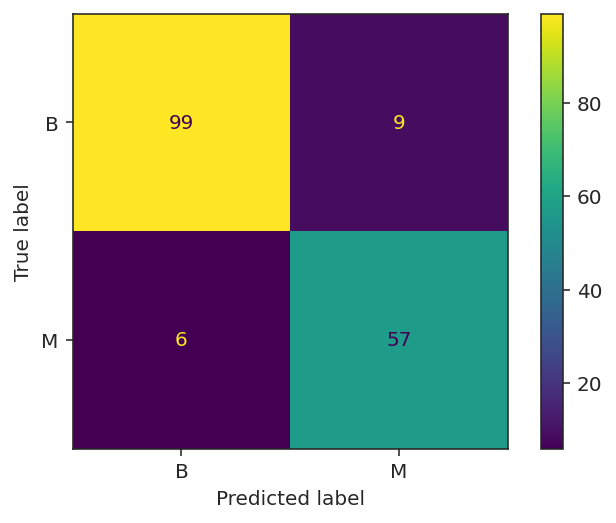

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels = clasificador.classes_)
# Solución gráfica
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clasificador.classes_)
# Representamos
disp.plot();

En la tabla de clasificación podemos ver como hay 156 muestras clasificadas correctamente frente a 15 que no lo están. 

En el informe completo de clasificación (que aparece justo debajo) podemos ver que hay una mayor exactitud a la hora de clasificar los tumores benignos (94%) que los malignos (86%). Esto implica que cuando es benigno tenemos más certeza de que lo clasificaremos como benigno, pero no ocurre lo mismo con los malignos.

En términos de precisión tenemos resultados similares para ambas etiquetas. Dado que la precisión es intuitivamente la capacidad del clasificador de no etiquetar como benigno una muestra que es maligna los resultados obtenidos son bastante buenos. 

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           B       0.94      0.92      0.93       108
           M       0.86      0.90      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.91       171
weighted avg       0.91      0.91      0.91       171



Para finalizar realizamos el análisis de las curvas ROC. En primer lugar obtenemos las probabilidades vinculadas al modelo entrenado, lo que nos permitirá obtener la curva ROC así como calcular el AUC score. Dado que la variable de etiquetas no está identificada con 0-1 es necesario asignar la etiqueta que asignamos al 1 para obtener la curva ROC. En este caso dicho valor se asigna a la etiqueta de "M" (orden alfabético). Esto se hace con el argumento `pos_label` de la función `roc_curve`. Tenemos la opción de construir una variable 0-1 a partir de la variable de etiquetas original y utilizarla para evaluar dicha curva.

In [ ]:
# Código para convertir variables de etiquetas a 0-1
y_train01 = pd.get_dummies(y_train, drop_first = True)
y_test01 = pd.get_dummies(y_test, drop_first = True)

Curva ROC con variable de etiquetas.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


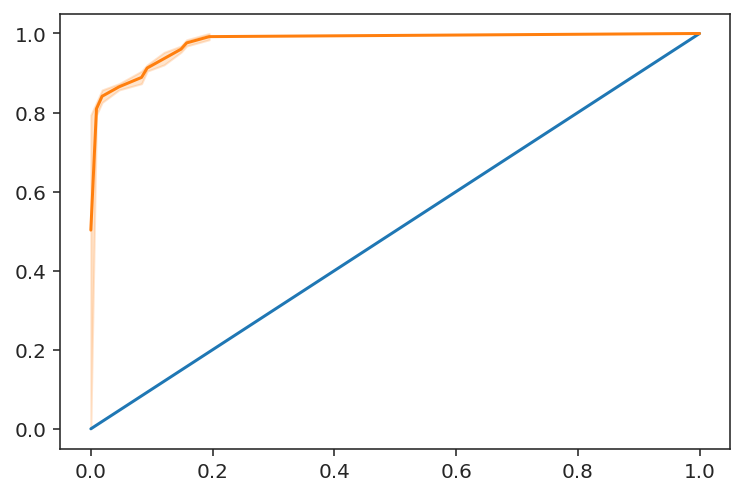

In [ ]:
# Calculamos y representamos curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], pos_label="M");
sns.lineplot([0, 1], [0, 1]);
sns.lineplot(fpr, tpr);

El comportamiento de la curva ROC indica (como era de esperar) que el modelo obtenido resulta útil para clasificar los tumores como benignos o malignos en función de las predictoras consideradas. Calculamos el área bajo la curva que nos proporciona un valor prácticamente de uno indicando la bondad del clasificador.

In [ ]:
# Área bajo la curva
round(roc_auc_score(y_test,y_prob[:,1]),3)

0.983

### Validación de la clasificación




Una vez visto el funcionamiento del clasificador obtenido llega el momento de validarlo mediante las técnicas habituales. En primer lugar utilizaremos los procedimientos de validación cruzada para estudiar la estabilidad de la solución, y posteriormente obtendremos las curvas de aprendizaje para ver como evoluciona la bondad del clasificador en función de los tamaños de las muestras de entrenamiento y validación.

Dividimos en 10 muestras de validación y utilizamos la exactitud para medir la bondad de dicho clasificador.

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(clasificador, X_train, y_train, cv=10, 
                                         scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.934744,0.031606,0.875,0.925,0.925,0.962019,0.975


La exactitud media se sitúa en el 93.4% pero hay cierta dispersión ya que observamos un diferencia del 10% entre el valor mínimo y el máximo. Aunque el clasificador proporciona buenos resultados en general vemos cierta inestabildiad debida a la muestra de entrenamiento utilizada. Pasamos a estudiar la curva de aprendizaje correspondiente a este modelo.

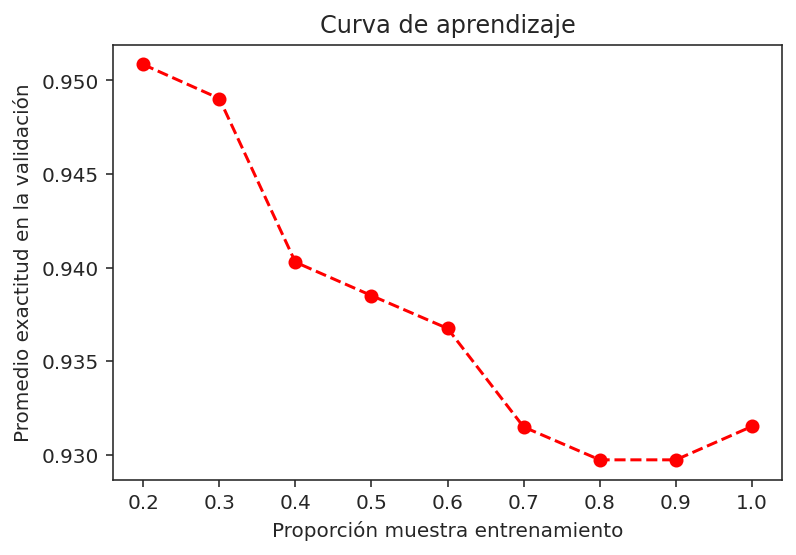

In [ ]:
#Fijamos tamaños de muestra de entrenamiento
size = np.linspace(0.2, 1, 9)
# Evaluamos la exactitud para los diferentes tamaños
train_sizes, train_scores, test_scores = learning_curve(
    clasificador, X_cancer, y_cancer, train_sizes=size, scoring="accuracy", cv=10)
# Representamos gráficamente
plt.plot(size, test_scores.mean(1), "o--", color="r", label="Validación")
plt.xlabel("Proporción muestra entrenamiento")
plt.ylabel("Promedio exactitud en la validación")
plt.title("Curva de aprendizaje")
plt.show()

La evolución de la curva de aprendizaje es mínima ya que desde tamaños de la muestra de entrenamiento muy pequeños la exactitud obtenida es muy alta.

### Calibración de probabilidades de clasificación

En este punto realizamos un análisis de calibración de las probabilidades obtenidas por el modelo de clasificación para estudiar las posibles distorsiones. En primer lugar obtenemos la curva de calibración asociada al modelo propuesto.

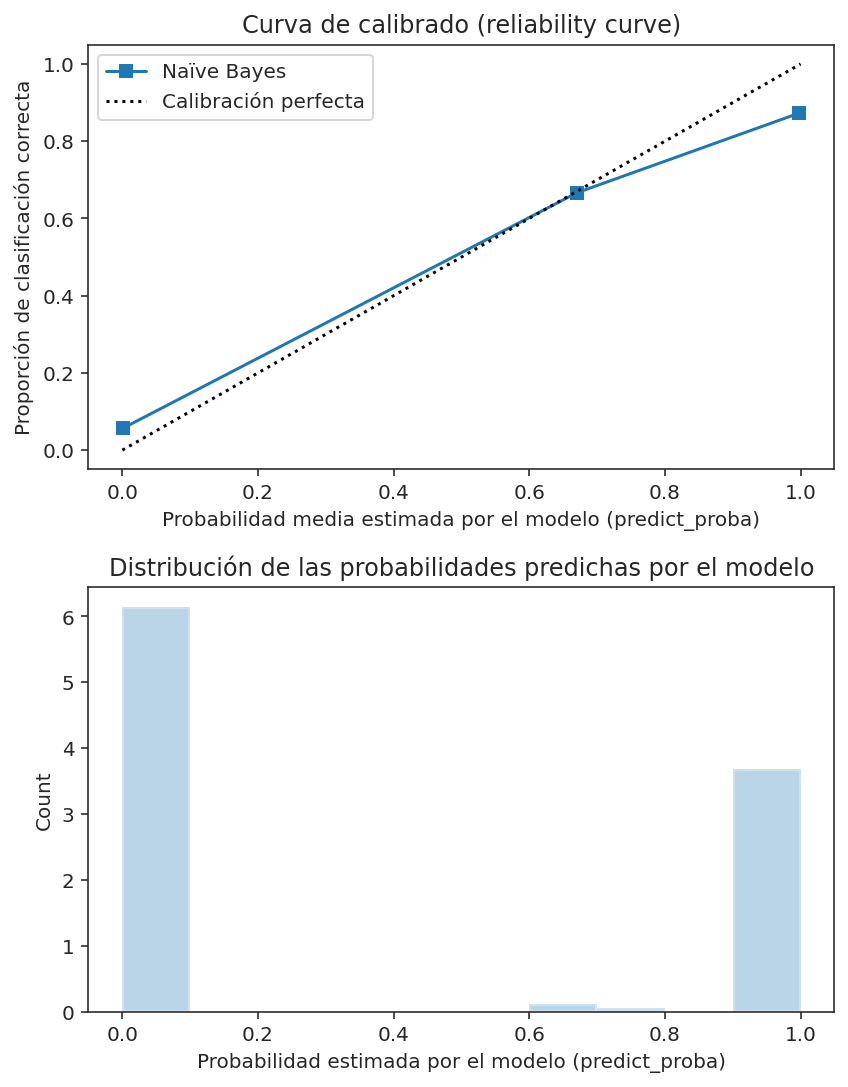

In [ ]:
# Valores para el gráfico
f_pos, m_prob_pred = calibration_curve(y_test, y_prob[:,1])

# Curva de calibrado
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))
axs[0].plot(m_prob_pred, f_pos, "s-", label="Naïve Bayes")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

# Histograma de probabilidades
axs[1].hist(y_prob[:,1], range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

Se aprecia cierta infravaloración de las probabilidades cuando estamos por encima del valor 0.6. Realizamos la calibración del modelo con los dos métodos disponibles. Aunque las curvas de calibración aportan información detallada, es interesante disponer de una métrica que permita cuantificar con un único valor la calidad de calibración del modelo. Brier score es la diferencia cuadrática media (mean squared difference) entre la probabilidad estimada por el modelo y la probabilidad real (1 para la clase positiva y 0 para la negativa). Cuanto menor es su valor, mejor calibrado está el modelo. Esta métrica es adecuada solo para clasificaciones binarias.

In [ ]:
# Modelos de calibrado
#######################

# Isotónico
clf_calibrado_iso = CalibratedClassifierCV(clasificador, cv=3, method='isotonic')
clf_calibrado_iso.fit(X_train, y_train)
prob_pos_isotonic = clf_calibrado_iso.predict_proba(X_test)[:, 1]
# Sigmoide
clf_calibrado_sig = CalibratedClassifierCV(clasificador, cv=3, method='sigmoid')
clf_calibrado_sig.fit(X_train, y_train)
prob_pos_sigmoid = clf_calibrado_sig.predict_proba(X_test)[:, 1]

# Score de Brier para comparar calibraciones
print("Brier score: (el más pequeño corresponde al mejor)")
clf_score = brier_score_loss(y_test, y_prob[:,1], pos_label="M")
print("Sin calibración: %1.3f" % clf_score)
clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, pos_label="M")
print("Con calibración isotónica: %1.3f" % clf_isotonic_score)
clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, pos_label="M")
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

Brier score: (el más pequeño corresponde al mejor)
Sin calibración: 0.085
Con calibración isotónica: 0.062
With sigmoid calibration: 0.072


El mejor modelo corresponde al de la calibración isotónica pero la diferencia es inapreciable. Obtenemos el informe resumen de métricas correspondiente al modelo calibrado.

In [ ]:
print(classification_report(y_test, clf_calibrado_iso.predict(X = X_test)))

              precision    recall  f1-score   support

           B       0.95      0.90      0.92       108
           M       0.84      0.92      0.88        63

    accuracy                           0.91       171
   macro avg       0.90      0.91      0.90       171
weighted avg       0.91      0.91      0.91       171



La métricas para el modelo calibrado son del mismo orden que las del modelo sin calibrar, por lo que podríamos optar por la solución sin calibrado.

Por todo lo obtenido anteriormente podemos afirmar que el clasificador Naïve Bayes Gaussiano que hemos ajustado clasifica de forma precisa el conjunto de datos.

## <font color="steelblue">Potabilidad del agua</font>

Para el segundo ejemplo utilizamos el conjunto de datos *water potability*, cuyo objetivo es clasificar el agua como potable o no potable. Como el preprocesamiento de la base de datos ya lo hemos realizado en cuadernos anteriores en este caso cargamos la base de datos ya preprocesada. De nuevo usamos el clasificador Naïve Bayes gaussiano ya que las predictoras son de tipo numérico.

In [ ]:
# Water clean potability
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/water_clean.csv'
water_clean = pd.read_csv(url, index_col = 0)

In [ ]:
water_clean.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,-0.025474,0.259195,-0.139471,0.112415,0.965957,1.708954,-1.180651,1.305434,-1.286298,0
1,-2.284717,-2.036414,-0.385987,-0.307694,-0.014799,2.062575,0.270597,-0.639186,0.684218,0
2,0.697319,0.847665,-0.240047,1.360594,-0.014799,-0.094032,0.781117,0.000800,-1.167365,0
3,0.845393,0.547651,0.000493,0.592008,0.644130,-0.778830,1.255134,2.152154,0.848412,0
4,1.372982,-0.464429,-0.460249,-0.363698,-0.649522,-0.343939,-0.824357,-2.182297,0.138786,0


Como hemos comentado, el objetivo es clasificar el agua como potable o no potable, por eso asignamos $y$ a la variable `Potability`.

In [ ]:
# objetivo
y_water = water_clean['Potability']
# matriz de características
X_water = water_clean.drop(columns ='Potability')

Escogemos que la muestra de validación tenga un 30% de los datos y la de entrenamiento un 70%.

In [ ]:
# División de muestras
X_train_water, X_test_water, y_train_water, y_test_water = train_test_split(X_water, y_water, test_size=0.30, random_state=42)

### Predicción y métricas de clasificación

Ajustamos y entrenamos el modelo, del que posteriormente obtenemos la bondad de la clasificación.

In [ ]:
# Ajuste modelo 
clasificador_water = GaussianNB().fit(X_train_water, y_train_water)

Realizamos predicciones con el clasificador ajustado sobre el conjunto de validación.

In [ ]:
# Predicciones modelo
y_pred_water = clasificador_water.predict(X_test_water)

Estimamos las probabilidades del clasificador sobre cada una de las clases de la variable objetivo.

In [ ]:
# Estición de probabilidades 
y_prob_water = clasificador_water.predict_proba(X_test_water)

A continuación, obtenemos la precisión de la clasificación tanto para el conjunto de entrenamiento como para el de validación.

In [ ]:
# clasificación muestras de entrenamiento
print('La exactitud en el conjunto de entrenamiento es: %.3f' % (
    np.round(clasificador_water.score(X_train_water, y_train_water),2)))
# clasificación muestras de validación
print('La exactitud en el conjunto de validación es: %.3f' % (
    np.round(clasificador_water.score(X_test_water, y_test_water),2)))

La exactitud en el conjunto de entrenamiento es: 0.630
La exactitud en el conjunto de validación es: 0.630


En este caso la exactitud sólo alcanza el 63% tanto en la muestra de entrenamiento como en la de validación. Estudiamos la tabla de confusión:

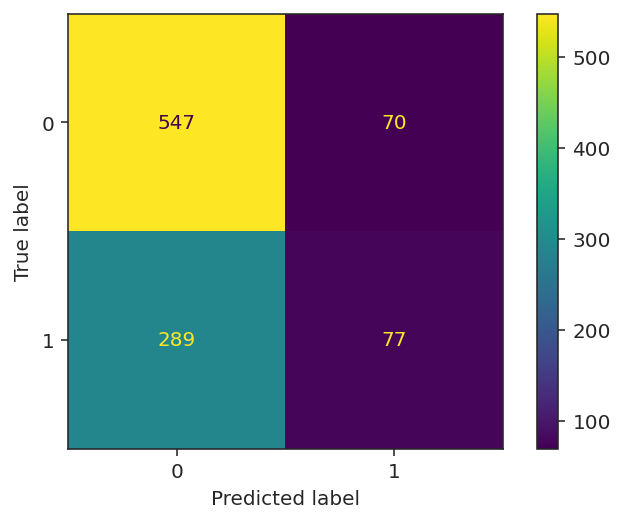

In [ ]:
# Matriz de confusión
cm_water = confusion_matrix(y_test_water, y_pred_water, labels = clasificador_water.classes_)
# Solución gráfica
disp_water = ConfusionMatrixDisplay(confusion_matrix=cm_water, display_labels=clasificador_water.classes_)
# Representamos
disp_water.plot();

En la tabla de clasificación podemos ver como hay 624 muestras clasificadas correctamente frente a 359 clasificadas incorrectamente. Aunque la predicción obtenida es bastante buena tenemos un problema para predecir de forma adecuada las muestras que originalmente se han clasificado como potables, ya que sólo clasificamos correctamente 77 de las 366 muestras consideradas. En este caso, como era de esperar por los resultados obtenidos en la matriz de clasificación, la precisión no es lo suficientemente alta como para considerar el clasificador adecuado.

Obtenemos el informe de clasificación correspondiente al modelo obtenido

In [ ]:
print(classification_report(y_test_water, y_pred_water))

              precision    recall  f1-score   support

           0       0.65      0.89      0.75       617
           1       0.52      0.21      0.30       366

    accuracy                           0.63       983
   macro avg       0.59      0.55      0.53       983
weighted avg       0.61      0.63      0.58       983



Se puede apreciar que las métricas de clasificación tienen valores muy bajos con lo que el modelo obtenido no permite discriminar de forma adecuada entre aguas potables y no potables en función de las predictoras consideradas.

Para finalizar realizamos el análisis de las curvas ROC. Como en este caso la variable respuesta ya está etiquetada con 0-1 no hace falta indicar la etiqueta de referencia como en el ejemplo anterior.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


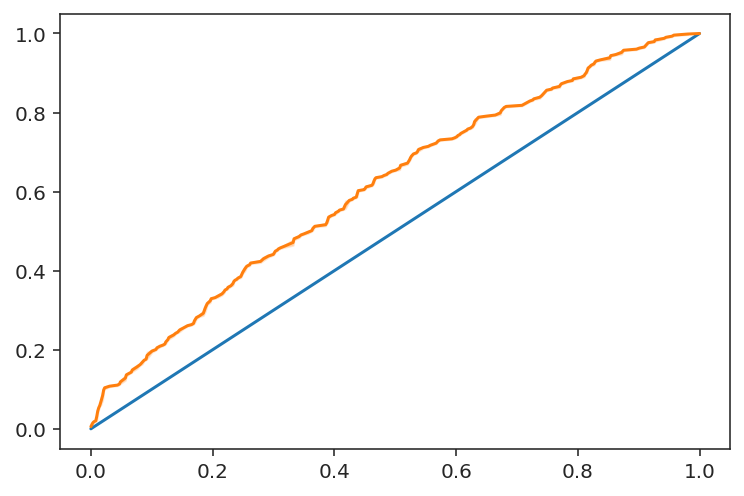

In [ ]:
# Calculamos y representamos curva ROC
fpr, tpr, thresholds = roc_curve(y_test_water, y_prob_water[:,1]);
sns.lineplot([0, 1], [0, 1]);
sns.lineplot(fpr, tpr);

La ruva ROC está un poco por encima de la diagonal pero sin mostrar buen poder clasificatorio. El área bajo la curva es de:

In [ ]:
round(roc_auc_score(y_test_water,y_prob_water[:,1]),3)

0.613

### Validación de la clasificación

Estudiamos la validez de la clasificación con los métodos habituales.

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(clasificador_water, X_train_water, y_train_water, cv=10, 
                                         scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.617501,0.022787,0.585153,0.603712,0.620087,0.631413,0.652174


El rango de valores de exactitud en el proceso de validación cruzada para las 10 muestras consideradas se mueve entre el 58.5% y el 65.2%, mostrando valores muy bajos. 

Realizamos un análisis de calibración para estudiar las probabilidades obtenidas con el modelo propuesto.

### Calibración de probabilidades de clasificación

Comenzamos obteniendo la curva de calibración




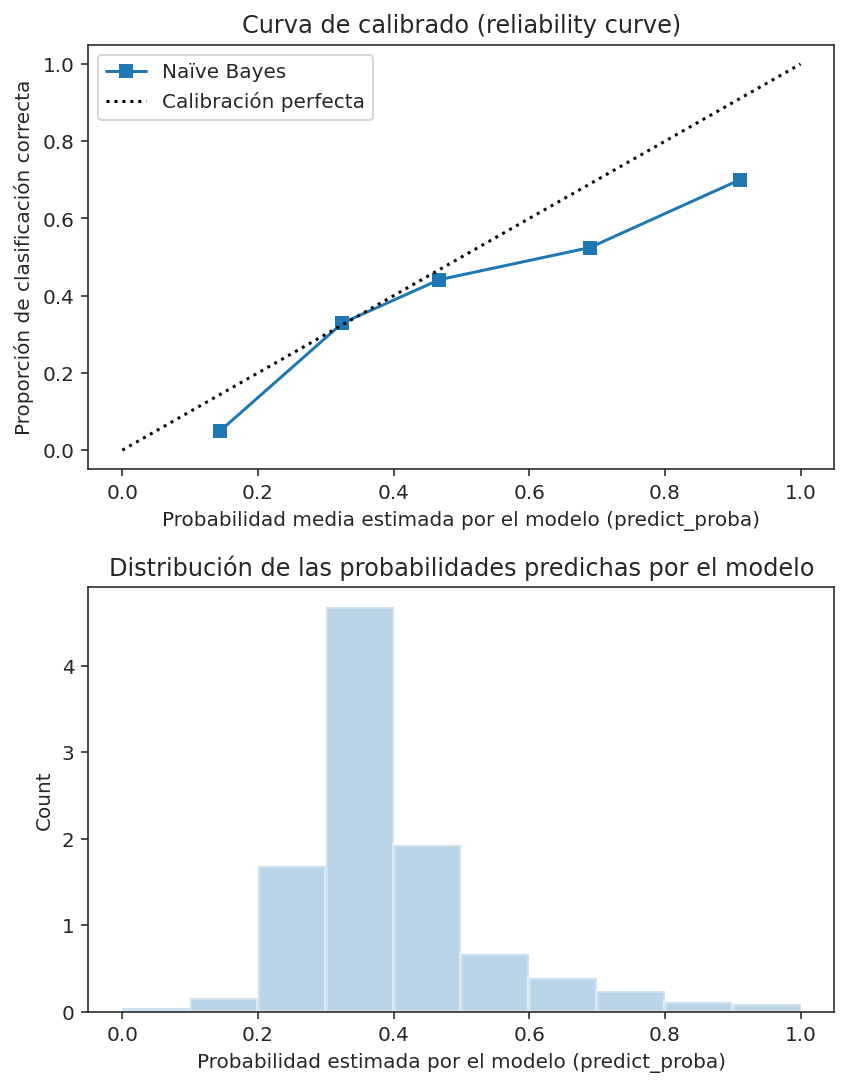

In [ ]:
# Valores para el gráfico
f_pos, m_prob_pred = calibration_curve(y_test_water, y_prob_water[:,1])

# Curva de calibrado
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))
axs[0].plot(m_prob_pred, f_pos, "s-", label="Naïve Bayes")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

# Histograma de probabilidades
axs[1].hist(y_prob_water[:,1], range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

La curva de calibrado muestra efectos poco deseables así que vamos a probar los métodos de calibración para tratar de mejorar la estimación de las probabilidades. En el histograma de probabilidades estimadas vemos que casi todos los valores se centran en 0.4, obteniendo pocos valores en los extremos. 

En primer lugar obtenemos el score de Brier tanto para el modelo planteado como para los calibrados.

In [ ]:
# Modelos de calibrado
#######################

# Isotónico
clf_calibrado_iso = CalibratedClassifierCV(clasificador_water, cv=3, method='isotonic')
clf_calibrado_iso.fit(X_train_water, y_train_water)
prob_pos_isotonic = clf_calibrado_iso.predict_proba(X_test_water)[:, 1]
# Sigmoide
clf_calibrado_sig = CalibratedClassifierCV(clasificador_water, cv=3, method='sigmoid')
clf_calibrado_sig.fit(X_train_water, y_train_water)
prob_pos_sigmoid = clf_calibrado_sig.predict_proba(X_test_water)[:, 1]

# Score de Brier para comparar calibraciones
print("Brier score: (el más pequeño corresponde al mejor)")
clf_score = brier_score_loss(y_test_water, y_prob_water[:,1])
print("Sin calibración: %1.3f" % clf_score)
clf_isotonic_score = brier_score_loss(y_test_water, prob_pos_isotonic)
print("Con calibración isotónica: %1.3f" % clf_isotonic_score)
clf_sigmoid_score = brier_score_loss(y_test_water, prob_pos_sigmoid)
print("Con calibración sigmoide: %1.3f" % clf_sigmoid_score)

Brier score: (el más pequeño corresponde al mejor)
Sin calibración: 0.226
Con calibración isotónica: 0.225
Con calibración sigmoide: 0.225


La diferencia entre el modelo original y los calibrados es ínfima dando a entender que el proceso de calibrado no resulta de utilidad.

Como conclusión el modelo Naïve Bayes propuesto para este banco de datos tiene poco poder clasificatorio y es necesario plantear modelos alternativos para este problema de clasificación. De hecho, la solución obtenida tiene el mismo poder de clasificación que el modelo de regresión logística que mostramos en cuadernos anteriores para este banco de datos.

## <font color="steelblue">Detección de spam</font>

El último ejemplo que vamos a mostrar en este cuaderno trata sobre la detección de spam en una bandeja de entrada de correo electrónico. 

A diferencia de los ejemplos anteriores queremos predecir la etiqueta de la respuesta a partir de una variable de texto y no de variables numéricas. Para poder tratar con este tipo de casos debemos proceder con un pretratamiento del texto de cada mensaje de foma que transformemos la información textual a valores numéricos. Se trata pues de una primera aproximación al procesado de lenguaje natural que estudiaremos con más detalle más adelante. 

En este caso vamos a ajustar un clasificador Naïve Bayes Multinomial ,que es el habitual en esta situación donde las predictoras muestran el número de repeticiones de los diferentes palabras o expresiones que parecen en cada uno de los mensajes de correo electrónico. 

En primer lugar cargamos los datos y vemos las cinco primeras muestras.

In [ ]:
# Spam
url = 'https://raw.githubusercontent.com/ia4legos/MachineLearning/main/data/spam_or_not_spam.csv'
spam = pd.read_csv(url)
spam.head()

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0


### Preprocesamiento

Leemos los datos y, en la cabecera, observamos que la base de datos contiene dos columnas, `email` y `label`. 

In [ ]:
spam.columns

Index(['email', 'label'], dtype='object')

Identificamos la existencia de valores perdidos

In [ ]:
spam.isnull().sum()

email    1
label    0
dtype: int64

Eliminamos el registro que no contiene información en la variable email, ya que es la que utilizamos como predictora. Al tratarse de una variable string resulta imposible imputar de forma adecuada. 

In [ ]:
spam = spam.dropna()

Asignamos predictora y respuesta.

In [ ]:
# objetivo
y_spam = spam['label']
# matriz de características
X_spam = spam['email']

Como en los ejemplos anteriores, escogemos el 30% de los datos para el conjunto de validación y el 70% para el conjunto de entrenamiento.

In [ ]:
# División de muestras
X_train_spam, X_test_spam, y_train_spam, y_test_spam = train_test_split(X_spam, y_spam, test_size=0.30, random_state=42)

Nuestro conjunto de datos sin preprocesar son los mensajes de correo electrónico, que están compuestos por palabras. Los algoritmos de aprendizaje automático entrenan modelos mediante cálculos, y el cálculo solo es posible si obtenemos valores numéricos. Para ello, lo que vamos a hacer es transformar los mensajes en vectores, de modo que realizamos un conteo de las palabras que aparecen en el email usando `CountVectorizer`.

En este caso solo analizamos las palabras de forma individual y la unión de dos palabras. Una vez realizado el conteo preparamos los datos para la construcción del algoritmo de clasificación.

In [ ]:
# Convertimos en vector de palabras cada uno de los emails
vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(X_train_spam)
X_train_vectorized = vectorizer.transform(X_train_spam)
# contamos la repetición de palabras y obtenemos la nueva matriz de predictoras
X_train_vectorized.toarray().shape

(2099, 210325)

La nueva matriz de predictoras tiene 210325 columnas al separar cada texto y realizar el conteo correspondiente.

### Predicción y métricas de clasificación

Ajustamos un clasificador Naïve Bayes Multinomial y estudiamos las métricas de clasificación habituales para determinar si el modelo propuesto es capaz de clasificar de forma adecuada el contenido de los correos electrónicos.

In [ ]:
# Ajuste modelo
clasificador_spam = MultinomialNB().fit(X_train_vectorized, y_train_spam)

A continuación realizamos predicciones sobre el conjunto de validación utilizando el clasificador recién ajustado.

In [ ]:
# Predicciones
y_pred_spam = clasificador_spam.predict(vectorizer.transform(X_test_spam))

Estimamos las probabilidades del clasificador sobre cada una de las clases de la variable objetivo.

In [ ]:
# Estimación de probabilidades 
y_prob_spam = clasificador_spam.predict_proba(vectorizer.transform(X_test_spam))

A continuación, obtenemos la precisión de la clasificación tanto para el conjunto de entrenamiento como para el de validación.

In [ ]:
# clasificación muestras de entrenamiento
print('La exactitud en el conjunto de entrenamiento es: %.3f' % (
    np.round(clasificador_spam.score(X_train_vectorized, y_train_spam),2)))
# clasificación muestras de validación
print('La exactitud en el conjunto de validación es: %.3f' % (
    np.round(clasificador_spam.score(vectorizer.transform(X_test_spam), y_test_spam),2)))

La exactitud en el conjunto de entrenamiento es: 1.000
La exactitud en el conjunto de validación es: 0.990


Tanto para la muestra de entrenamiento como la de validación el modelo muestra una exactitud casi perfecta. Casi todos los correos electrónicos son clasificados de forma correcta. Estudiamos la matriz de confusión.

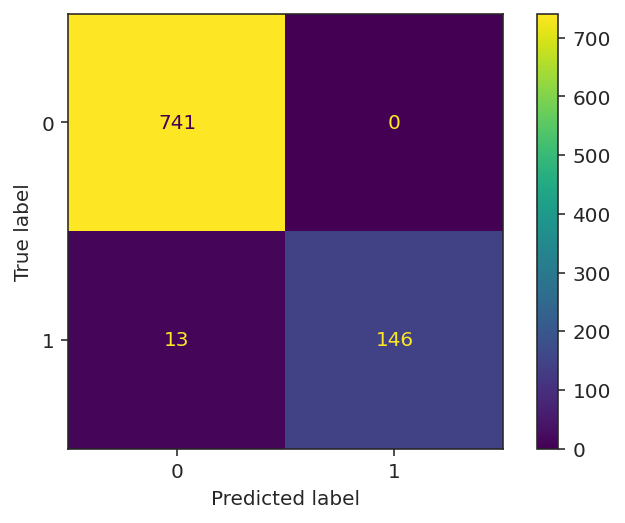

In [ ]:
# Matriz de confusión
cm_spam = confusion_matrix(y_test_spam, y_pred_spam, labels = clasificador_spam.classes_)
# Solución gráfica
disp_spam = ConfusionMatrixDisplay(confusion_matrix=cm_spam, display_labels=clasificador_spam.classes_)
# Representamos
disp_spam.plot();

De los 900 correos que componen la muestra de validación 887 son clasificados correctamente. Sólo vemos que hay 13 correos que manualmente fueron clasificados como spam pero que el algoritmo clasifica como no spam. El área bajo la curva para este modelo viene dada por:

In [ ]:
round(roc_auc_score(y_test_spam,y_prob_spam[:,1]),3)

0.985

mostrando que la capacidad clasificadora del algoritmo planteado es muy alta.

### Validación de la clasificación

Estudiamos la validez de la clasificación con los métodos habituales.

In [ ]:
# Obtenemos los scores de validación
score_val = pd.DataFrame(cross_val_score(clasificador_spam, X_train_vectorized, y_train_spam, cv=10, 
                                         scoring ='accuracy'), columns=['score'])
# Describios los valores obtenidos
score_val.describe().T

,count,mean,std,min,25%,50%,75%,max
score,10.0,0.989995,0.004735,0.980952,0.986893,0.990476,0.994048,0.995238


Los valores obtenidos confirman el buen funcionamiento del algoritmo de clasificación. 

### Calibración de probabilidades de clasificación

Obtenemos la curva de calibración correspondeinte a este problema

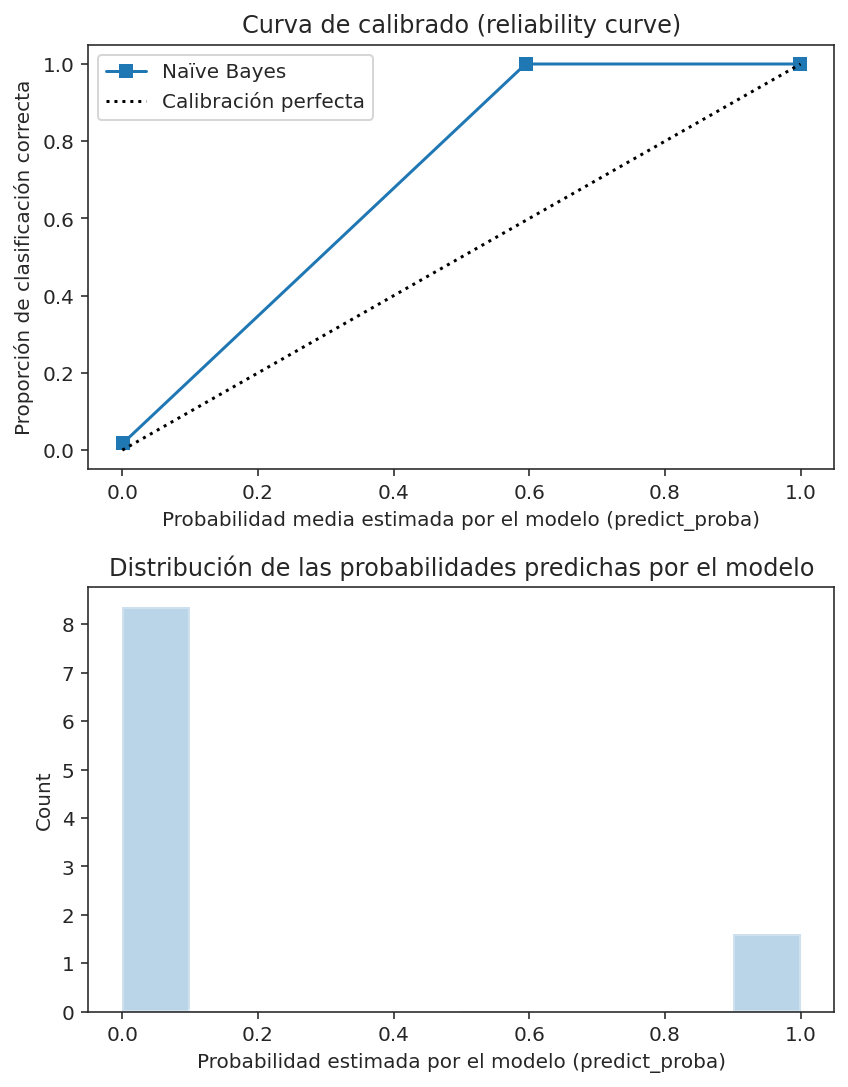

In [ ]:
# Valores para el gráfico
f_pos, m_prob_pred = calibration_curve(y_test_spam, y_prob_spam[:,1])

# Curva de calibrado
fig, axs = plt.subplots(nrows=2, ncols=1,figsize=(6, 2*3.84))
axs[0].plot(m_prob_pred, f_pos, "s-", label="Naïve Bayes")
axs[0].plot([0, 1], [0, 1], "k:", label="Calibración perfecta")
axs[0].set_ylabel("Proporción de clasificación correcta")
axs[0].set_xlabel("Probabilidad media estimada por el modelo (predict_proba)")
axs[0].set_title('Curva de calibrado (reliability curve)')
axs[0].legend()

# Histograma de probabilidades
axs[1].hist(y_prob_spam[:,1], range=(0, 1), bins=10, density=True, lw=2, alpha = 0.3)
axs[1].set_xlabel("Probabilidad estimada por el modelo (predict_proba)")
axs[1].set_ylabel("Count")
axs[1].set_title('Distribución de las probabilidades predichas por el modelo')

plt.tight_layout()
plt.show();

Se observa cierta sobre estimación de las probabilidades más pequeñas con lo que considerar posibles calibraciones sería el siguiente paso. Dado que sólo tenemos dos probabilidades posibles calculamos la curva de calibrado en esos dos puntos para conocer las diferencias entre las probabilidades reales y las estimadas por el modelo.

In [ ]:
# Curva de calibrado en 0 y 1
prob_true, prob_pred = calibration_curve(y_test_spam, y_prob_spam[:,1], n_bins=3)
# Probabilidad real
print(np.around(prob_true, decimals=4))
# Probabilidad estimada
print(np.around(prob_pred, decimals=4))


[0.0172 1.     1.    ]
[5.000e-04 5.946e-01 9.992e-01]


Se puede ver que la diferencia entre probabilidades reales y predichas en las probabilidades más extremas (0 o 1) es mínimo, en el centro de la distribución es de 0.5. Sin embargo, dado que todas las probabilidades son 0 o 1 el problema de calibración es mínimo, como se puede comprobar si obtenemos los scores de Brier tanto para el modelo sin calibrar como para los calibrados. 

# <font color="steelblue">Referencias y enlaces de interés</font>





Manuales

* Aurélien Géron (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. O’Reilly Media.

* Peters Morgan (2018). Data Analysis From Scratch With Python: Beginner Guide using Python, Pandas, NumPy, Scikit-Learn, IPython, TensorFlow and Matplotlib. AI Sciences LLC.

* Sebastian Raschka, Vahid Mirjalili (2017). Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow. Packt Publishing.

* Julian Avila (2017). Scikit-Learn Cookbook: Over 80 Recipes for Machine Learning in Python With Scikit-Learn. Packt Publishing

Enlaces

* Scikit-Learn. Naïve Bayes: https://scikit-learn.org/stable/modules/naive_bayes.html

* Amat, J. (2020). https://www.cienciadedatos.net/documentos/py11-calibrar-modelos-machine-learning.html


* Jake VanderPlas. (2016) https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.05-Naive-Bayes.ipynb#scrollTo=NMlQKNcJSc7s